We'll forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

Let's create a model that predicts the unit sales for thousands of items sold at different Favorita stores. I use this competition to apply knowledge from Auto.ru project on something more real (not only competitions from online-course). The goal is to practice my machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/store-sales-time-series-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import of libraries

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as rmsle
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model

In [ ]:
events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')

Let's look at our dataset

In [ ]:
train

In [ ]:
test

Huge amount of data ruins following calculations and don't improve a lot results of prediciton as submission dataset is 2017. So, let's drop the oldest data

In [ ]:
train = train.drop(train.index[0:2300000])
import datetime as dt
train['date'] = pd.to_datetime(train['date'])
#train['month'] = train['date'].dt.month
test['date'] = pd.to_datetime(test['date'])
#test['month'] = test['date'].dt.month
#train['year'] = train['date'].dt.year
#test['year'] = test['date'].dt.year
#train_2017 = train[train['year'] == 2017]
#train = train.drop(train[(train['year'] != 2016)&(train['year'] != 2015)].index)
#train = train.drop(train[(train['month'] != 8)].index)

Mark train and test dataset and merge them

In [ ]:
#train['week'] = train['date'].dt.week
#test['week'] = test['date'].dt.week

In [ ]:
#train['week'].value_counts()

In [ ]:
#test['week'].value_counts()

In [ ]:
#train = train.drop(train[(train['week'] != 33) & (train['week'] != 34) & (train['week'] != 35) & (train['week'] != 36)].index)
#train = train.append(train_2017,sort = False).reset_index(drop = True)
#train

In [ ]:
train['drop'] = 0
test['drop'] = 1

In [ ]:
data = test.append(train, sort=False).reset_index(drop=True)
#data = data.drop(['month', 'week'], axis = 1)

In [ ]:
data

We have to add date of the week

In [ ]:
import datetime as dt
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_week'] = data['day_of_week'].apply(lambda x: "weekend" if (x==5 or x ==6) else 'working day')
data

In [ ]:
stores.head()

In [ ]:
events.head()

In [ ]:
oil.plot(x="date", y='dcoilwtico', figsize = (15,10))
plt.show()

Any sense to use values vefore 2015 ? 

Add city,state, type, cluster of stores; Add holiday or not holiday to date in initial dataset (maybe once with transfered or not); add oil rate to the date.

To do this - date to datetime everywhere, merge by date and regarding stores - merge by store_nbr

Let's do it

In [ ]:
data1 = data.merge(stores, how = 'left', on = 'store_nbr' )
data1

In [ ]:
events['date'] = pd.to_datetime(events['date'])
oil['date'] = pd.to_datetime(oil['date'])

In [ ]:
events['transferred'] = events['transferred'].astype(str)
#events['transferred'].value_counts()
events['type'] = events.apply(lambda x: 'transfer' if x['transferred'] == 'True' else x['type'], axis =1)
events[events['transferred']=='True']

we have NA due to holidays, prices for previous days of the week can be used

In [ ]:
data2 = data1.merge(events, how = 'left', on = 'date' )
data2 = data2.merge(oil, how ='left', on ='date')
data2

Now we replace working days by holidays if any

In [ ]:
data2['day_type'] = data2.apply(lambda x: 'holiday' if (x['type_y'] == 'Holiday' and x['locale'] != 'Local')\
                                else ('transfer' if (x['type_y'] == 'transfer' and x['locale'] != 'Local')\
                                else ('local_holiday' if (x['type_y'] == 'Holiday' and x['locale'] == 'Local') \
                                else ('local_transfer' if (x['type_y'] == 'transfer' and x['locale'] == 'Local') else x['day_of_week']))), axis = 1)
data2

In [ ]:
#data2[data2['transferred']=='True']
data2['day_type'].value_counts()

Filling oil prices for weekends and holidays by previous working day's price

In [ ]:
data2['dcoilwtico'] = data2['dcoilwtico'].fillna(method='ffill')

In [ ]:
data2.plot(x="date", y='dcoilwtico', figsize = (15,10))
plt.show()

Check it

In [ ]:
data2[(data2['date']=='2014-08-15') | (data2['date']=='2014-08-16')]

Useless columns = locale_name, description, locale. Also drop day of the week and type_y as we have merged column day_type

In [ ]:
#data2 = data2.drop(['locale_name', 'description', 'locale', 'type_y', 'day_of_week', 'transferred','month'], axis =1 )
data2 = data2.drop(['locale_name', 'description', 'locale', 'type_y', 'day_of_week', 'transferred'], axis =1 )
data2.info()

For categorial features we'll do a check of impact on sales

Transform categorical features to numeric by LabelEncoder

In [ ]:
cat = ['family', 'city', 'state','type_x', 'day_type']
label_encoder = LabelEncoder()
for column in cat:
    data2[column] = label_encoder.fit_transform(data2[column])

In [ ]:
data2.min()

In [ ]:
#num_cols = ['store_nbr', 'family', 'onpromotion','city', 'state', 'type_x', 'cluster', 'type_y', 'transferred','dcoilwtico']
num_cols_heat = ['sales','store_nbr', 'family', 'onpromotion','city', 'state', 'type_x', 'cluster','dcoilwtico', 'day_type']

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(train2[num_cols_heat].corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)

Change date format to numeric

In [ ]:
data2['date']=data2['date'].map(dt.datetime.toordinal)
#train2['date']=train2['date'].map(dt.datetime.toordinal)

Creation of 3 additional features didn't improve prediciton results. Still, I'll keep it here, it can be used for further improvement.

In [ ]:
#train2['f1'] = train2['onpromotion'] * train2['family']
#train2['f2'] = train2['family'] * train2['type_x']
#train2['f3'] = train2['date'] * train2['state']*train2['dcoilwtico']

Let's look at correcaltion matrix with Date column

In [ ]:
num_cols_heat1 = ['date','sales','store_nbr', 'family', 'onpromotion','city', 'state', 'type_x', 'cluster','dcoilwtico', 'day_type']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data2[num_cols_heat1].corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)

For numeric data we check mathematical distribution

In [ ]:
num_cols_check1 = ['date', 'store_nbr','family','state','type_x','onpromotion','dcoilwtico']
for i in num_cols_check1:
    plt.figure()
    sns.distplot(data2[i][data2[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Trying to apply logarythm for normal distribution

In [ ]:
data2['f1'] = data2['onpromotion'] * data2['family'] * data2['state']
data2['f2'] = data2['type_x'] * data2['dcoilwtico'] * data2['store_nbr']
data2['f3'] = data2['f2']*data2['f1']

In [ ]:
data2['onpromotion'] = np.log1p(data2['onpromotion'])
data2['dcoilwtico'] = np.log1p(data2['dcoilwtico'])
data2['f1'] = np.log1p(data2['f1'])
data2['f2'] = np.log1p(data2['f2'])
data2['f3'] = np.log1p(data2['f3'])
#pd.set_option('mode.use_inf_as_na', True)
#data2['onpromotion'] = data2['onpromotion'].fillna(0)
#data2['f2'] = data2['family'] * data2['type_x']

In [ ]:
#imp_num = pd.Series(f_classif(train2[num_cols], train2['sales'])[0], index = num_cols)
#imp_num.sort_values(inplace = True)
#imp_num.plot(kind = 'barh')

In [ ]:
data2.f3.value_counts()

In [ ]:
num_cols_check = ['onpromotion','dcoilwtico','f1','f2','f3']
for i in num_cols_check:
    plt.figure()
    sns.distplot(data2[i][data2[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [ ]:
train_for_feature = data2.query('drop == 0').drop(['drop'], axis=1)
imp_num = pd.Series(f_classif(train_for_feature[num_cols_check], train_for_feature['sales'])[0], index = num_cols_check)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

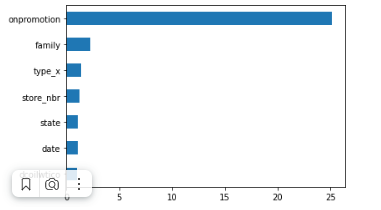

In [ ]:
data2

In [ ]:
#scaler = StandardScaler()

scaler = MinMaxScaler()

Trying to decrease amount of array for further predictions by scaler

In [ ]:
data2[['date', 'store_nbr','family','state','type_x','onpromotion','day_type', 'dcoilwtico','city','cluster','f1','f2','f3']] = scaler.fit_transform(data2[['date', 'store_nbr','family','state','type_x','onpromotion','day_type','dcoilwtico','city','cluster','f1','f2','f3']])
#data2[['store_nbr','family','type_x','onpromotion','dcoilwtico','day_type']] = scaler.fit_transform(data2[['store_nbr','family','type_x','onpromotion','dcoilwtico','day_type']])

In [ ]:
#data2['date'] = np.log(data2['date'])
#data2['store_nbr'] = np.log(data2['store_nbr'])
#data2['family'] = np.log(data2['family'])
#data2['state'] = np.log(data2['state'])
#data2['type_x'] = np.log(data2['type_x'])
#data2['onpromotion'] = np.log(data2['onpromotion'])
#data2['dcoilwtico'] = np.log(data2['dcoilwtico'])

In [ ]:
data2 = data2.drop(['city','cluster'],axis =1)
#data2 = data2.drop(['city','cluster','store_nbr','state','type_x','f2','dcoilwtico'],axis =1)

In [ ]:
test = data2.query('drop == 1').drop(['drop'], axis=1)
train = data2.query('drop == 0').drop(['drop'], axis=1)

In [ ]:
test = test.drop('sales',axis = 1)
test.min()

In [ ]:
X = train.drop(['sales','id'],axis = 1)
y = train['sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#quantile_transformer = preprocessing.QuantileTransformer(random_state=42)
#X_train_trans = quantile_transformer.fit_transform(X_train)
#X_test_trans = quantile_transformer.transform(X_test)

In [ ]:
#pt = preprocessing.PowerTransformer( standardize=False)
#X_train_log = pt.fit_transform(X_train)
#X_test_log = pt.transform(X_test)
#y_train_log = np.log1p(y_train)
#y_test_log = np.log1p(y_test)

Trying different regressors

In [ ]:
#DTR = DecisionTreeRegressor(criterion="squared_error", random_state = 42)
#DTR.fit(X_train_log,y_train)

In [ ]:
#predict_DTR = DTR.predict(X_test)

In [ ]:
#print(f"RMSLE accuracy: {(rmsle(y_test, predict_DTR))*100:0.2f}%")

Decision tree regressor showed low results

In [ ]:
RFR = RandomForestRegressor(n_estimators=100,random_state=42, verbose = 1, n_jobs = -1)
RFR.fit(X_train, y_train)

#  , ccp_alpha = 0.5

In [ ]:
predict_RFR = RFR.predict(X_test)
print(f"RMSLE accuracy: {(rmsle(y_test, predict_RFR))*100:0.2f}%")

In [ ]:
#clf = linear_model.GammaRegressor().fit(X_train, y_train)
#predict_clf = clf.predict(X_test)

In [ ]:
#rdg = Ridge(alpha = 0.5).fit(X_train, np.log1p(y_train)) 
#predict_rdg = np.expm1(rdg.predict(X_test))

In [ ]:
#print(f"RMSLE accuracy: {(rmsle(y_test, predict_rdg))*100:0.2f}%")

In [ ]:
#SGD = SGDRegressor(max_iter=1000, tol=1e-3, verbose = 1).fit(X_train, np.log1p(y_train)) 
#predict_SGD = np.expm1(SGD.predict(X_test))

In [ ]:
#print(f"RMSLE accuracy: {(rmsle(y_test, predict_SGD))*100:0.2f}%")

Not brilliant results. What can be improved - to parse oil prices instead of median, add aditional feature which will take into account a day before the holiday + promotion effect on sales

In [ ]:
#estimators = [('sd',SGDRegressor(max_iter=1000, tol=1e-3, verbose = 1))]
#reg = StackingRegressor(estimators=estimators,final_estimator= RandomForestRegressor(n_estimators=100,random_state=42)).fit(X_train,y_train)
#predict = reg.predict(X_test)

In [ ]:
#predict

In [ ]:
#predict = predict.clip(0.0)
#print(f"RMSLE accuracy: {(rmsle(y_test, predict))*100:0.2f}%")

In [ ]:
#GBR = GradientBoostingRegressor(alpha=0.9,criterion='friedman_mse', random_state=42,learning_rate=0.1, verbose = 1)
#GBR.fit(X_train_log, y_train)

In [ ]:
#predict_GBR = GBR.predict(X_test)
#print(f"RMSLE accuracy: {(rmsle(y_test, predict_GBR))*100:0.2f}%")

In [ ]:
#log = LinearRegression(positive = True).fit(X_train, y_train)
#predict_log = log.predict(X_test)

In [ ]:
#predict_log = predict_log.clip(0.0)

In [ ]:
#print(f"RMSLE accuracy: {(rmsle(y_test, predict_log))*100:0.2f}%")

In [ ]:
X_sub = test.drop('id', axis = 1)

In [ ]:
predict_RFR_sub = RFR.predict(X_sub)

In [ ]:
#predict_SGD_sub = SGD.predict(X_sub)

In [ ]:
submission['sales'] = predict_RFR_sub
#submission['sales'] = predict_SGD_sub

In [ ]:
submission

Some of products are sold only by integer values, we have to correct submission

In [ ]:
check = test.merge(submission, how = 'left', on = 'id' )

In [ ]:
check['sales'] = check['sales'].apply(lambda x: 0 if x<0 else x)

In [ ]:
check_train = train.groupby(['family']).max('sales')
check_train['correction'] = check_train['sales'].apply(lambda x: 'int' if x/int(x) == 1 else 'float')

In [ ]:
check2 = check.merge(check_train['correction'], how = 'left', on = 'family' )
check2['sales'] = check2.apply(lambda x: round(x['sales']) if x['correction'] == 'int' else x['sales'], axis =1)

In [ ]:
submission = check2.drop(['date', 'store_nbr', 'family', 'onpromotion', 'state', 'type_x','dcoilwtico','day_type','correction','f1','f2','f3'], axis =1 )
submission.to_csv('./submission.csv', index = False)
submission.head(10)


In [ ]:
gg = pd.read_csv('./submission.csv')
gg.info()

In [ ]:
#import xgboost as xgb

XGB boosting didn't improve results

In [ ]:
#xgbr = xgb.XGBRegressor(verbosity=1,learning_rate=0.1,max_depth = 10, n_estimators = 200,random_state=42) 
#xgbr.fit(X_train, y_train)
#predict_xgbr = xgbr.predict(X_test)

In [ ]:
#for x in range(len(predict_xgbr)):
#    if predict_xgbr[x]<0:
#        predict_xgbr[x]=0

In [ ]:
#predict_xgbr

In [ ]:
#RFR = RandomForestRegressor(n_estimators=100,max_depth = 10,random_state=42,verbose = 1)
#RFR.fit(X_train, y_train)
#predict_RFR = RFR.predict(X_test)

In [ ]:
#print(f"Точность модели по метрике RMSLE: {(rmsle(y_test, predict_RFR))*100:0.2f}%")